Model fitting 2: SSC + galaxy template
======================================


In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs


In [2]:
print(jetset.__version__)

1.2.2


In [3]:
test_SEDs

['/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [4]:
data=Data.from_file(test_SEDs[3])



***  binning data  ***
---> N bins= 90
---> bin_widht= 0.2



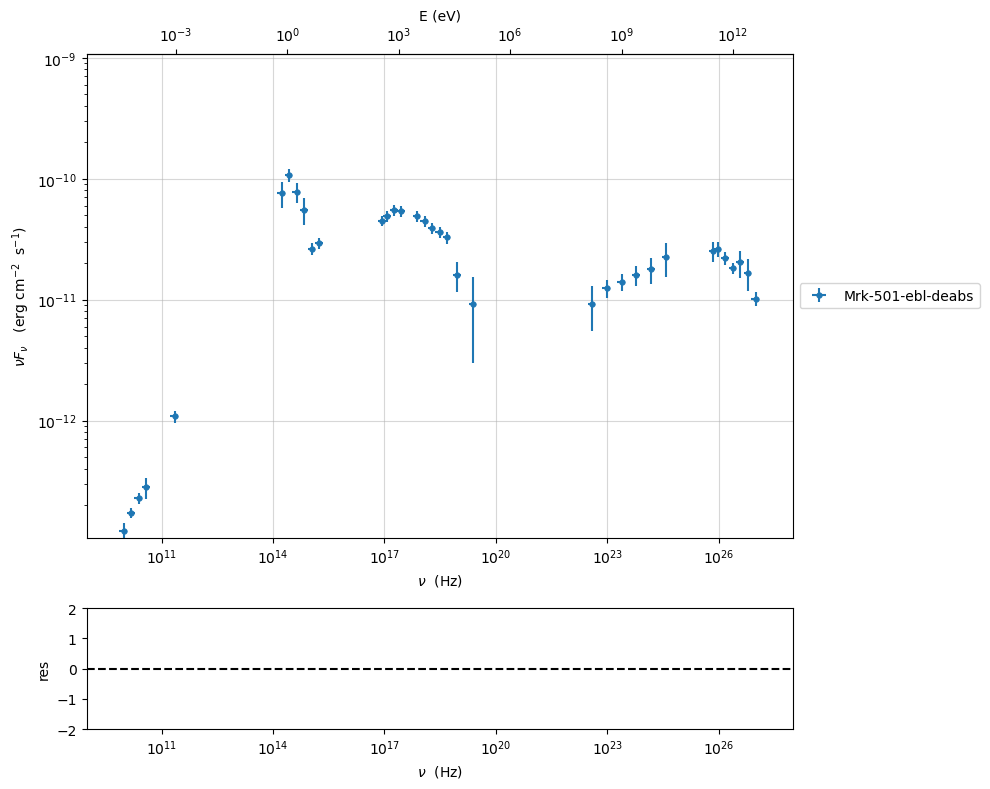

In [5]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [6]:
sed_data.save('Mrk_501.pkl')

## Phenomenological model constraining

### Spectral indices


*** evaluating spectral indices for data ***



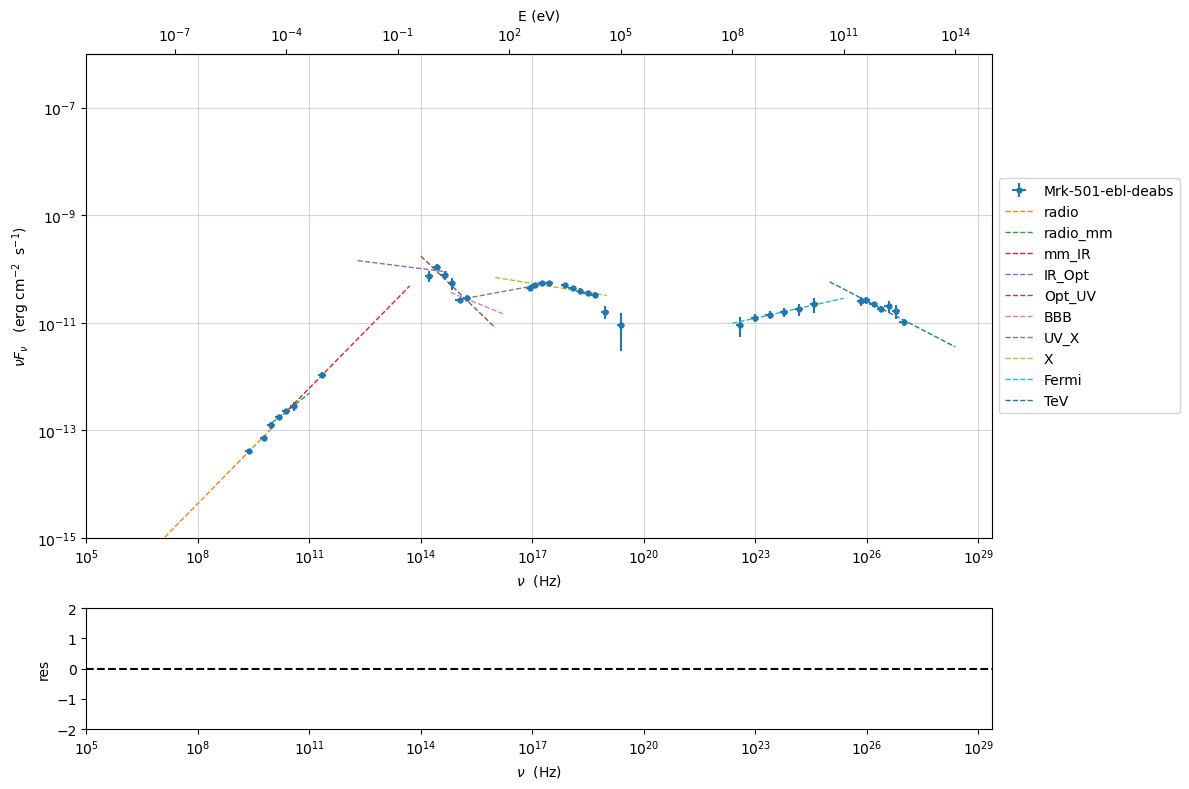

In [7]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.setlim(y_min=1E-15,y_max=1E-6)

### Sed shaper

In [8]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=True,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10. , 21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP

---> class:  HSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-6.411143e-02,-6.411143e-02,7.838958e-03,--,-4.778764e-02,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.751705e-03,-1.751705e-03,1.127020e-03,--,3.576201e-03,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.703747e+01,1.703747e+01,9.437333e-02,--,1.626870e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.030068e+01,-1.030068e+01,1.884116e-02,--,-1.025412e+01,-3.000000e+01,0.000000e+00,False
host_galaxy,nuFnu_p_host,-1.006556e+01,-1.006556e+01,5.462500e-02,--,-1.025412e+01,-1.225412e+01,-8.254123e+00,False
host_galaxy,nu_scale,1.730750e-02,1.730750e-02,3.694838e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.703747e+01 (err=+9.437333e-02)  nuFnu_p=-1.030068e+01 (err=+1.884116e-02) curv.=-6.411143e-02 (err=+7.838958e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.310993e-01,-1.310993e-01,3.244183e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-3.300446e-02,-3.300446e-02,2.072517e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.549603e+01,2.549603e+01,2.235468e-01,--,2.556357e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.057945e+01,-1.057945e+01,4.332976e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.549603e+01 (err=+2.235468e-01)  nuFnu_p=-1.057945e+01 (err=+4.332976e-02) curv.=-1.310993e-01 (err=+3.244183e-02)



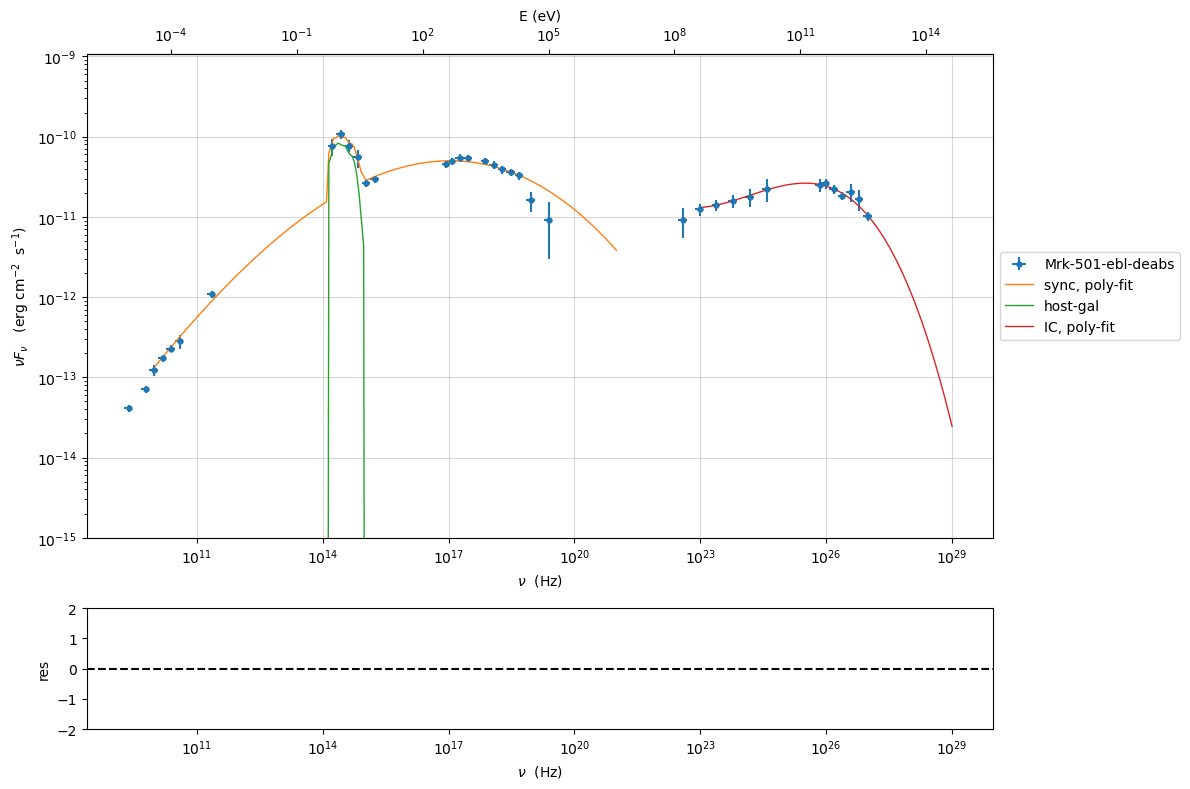

In [9]:
my_shape.IC_fit(fit_range=[23., 29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [10]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_gal_templ.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.046428e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082271e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045836e+04,1.000000e+00,1.000000e+09,False,False


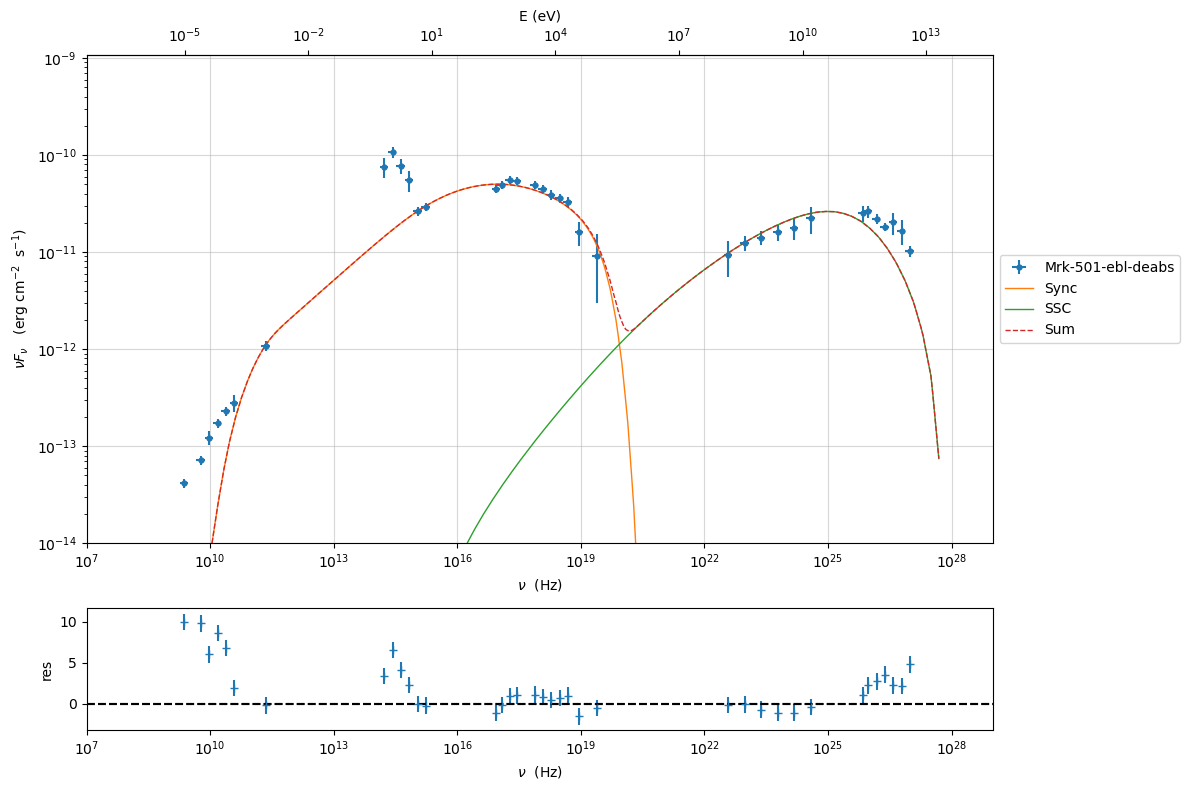

In [11]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.setlim(y_min=1E-14,x_min=1E7,x_max=1E29)

## Model fitting

### Model fitting with LSB

In [12]:
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_lsb=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_lsb.set_gamma_grid_size(200)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082271e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045836e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205571e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046428e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True


In [13]:
fit_model_lsb=FitModel( jet=jet_lsb, name='SSC-best-fit-lsb',template=my_shape.host_gal) 
fit_model_lsb.show_model()


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
individual component description

--------------------------------------------------------------------------------
model description: 
--------------------------------------------------------------------------------
type: Jet
name: jet_leptonic  

electrons distribution:
 type: lppl  
 gamma energy grid size:  201
 gmin grid : 1.487509e+02
 gmax grid : 2.310708e+06
 normalization:  True
 log-values:  False
 ratio of cold protons to relativistic electrons: 1.000000e-01

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  100
 source emissivity

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082271e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045836e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205571e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046428e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True


--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
model description
--------------------------------------------------------------------------------
name: host_galaxy  
type: template  

--------------------------------------------------------------------------------


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
host_galaxy,nuFnu_p_host,nuFnu-scale,erg / (cm2 s),-1.006556e+01,-2.000000e+01,2.000000e+01,False,False
host_galaxy,nu_scale,nu-scale,Hz,1.730750e-02,-2.000000e+00,2.000000e+00,False,False


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [14]:
fit_model_lsb.composite_expr='jet_leptonic + host_galaxy'

In [15]:
fit_model_lsb.freeze('jet_leptonic','z_cosm')
fit_model_lsb.freeze('jet_leptonic','R_H')
fit_model_lsb.jet_leptonic.parameters.N.fit_range=[1E-10, 1E5]
fit_model_lsb.jet_leptonic.parameters.B.fit_range=[1E-3, 1]

fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model_lsb.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb.host_galaxy.parameters.nu_scale.frozen=True

In [16]:
from jetset.minimizer import fit_SED,ModelMinimizer

model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-lsb',repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=8.38525e+00

fit run: 1
- old chisq=8.38525e+00


0it [00:00, ?it/s]

- best chisq=8.38525e+00

fit run: 2
- old chisq=8.38525e+00


0it [00:00, ?it/s]

- best chisq=8.38525e+00

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.035366e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.110441e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.378511e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,6.124079e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.183323e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,2.298521e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.416426e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.264063e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True



converged=True
calls=21
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=21
chisq=8.385251, chisq/red=0.399298 null hypothesis sig=0.993283

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.035366e+02,1.035366e+02,3.138045e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.110441e+06,2.110441e+06,1.851406e+06,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.378511e+01,2.378511e+01,1.413286e+02,--,3.082271e+01,1.000000e-10,1.000000e+05,False
jet_leptonic,gamma0_log_parab,6.124079e+03,6.124079e+03,9.244801e+03,--,1.045836e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.183323e+00,2.183323e+00,1.197420e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.298521e-01,2.298521e-01,4.200536e-02,--,3.205571e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.416426e+16,1.416426e+16,3.597031e+16,--,1.046428e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.264063e-02,1.264063e-02,9.772826e-03,--,5.050000e-02,1.000000e-03,1.000000e+00,False
jet_leptonic,NH_cold_to_rel_e,1.000000e-01,--,--,--,1.000000e-01,0.000000e+00,--,True


-------------------------------------------------------------------------




In [17]:
best_fit_lsb.save_report('SSC-best-fit-lsb.pkl')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model_lsb.save_model('fit_model_lsb.pkl')

best_fit_lsb.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,1.035366e+02,1.035366e+02,3.138045e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.110441e+06,2.110441e+06,1.851406e+06,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.378511e+01,2.378511e+01,1.413286e+02,--,3.082271e+01,1.000000e-10,1.000000e+05,False
jet_leptonic,gamma0_log_parab,6.124079e+03,6.124079e+03,9.244801e+03,--,1.045836e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.183323e+00,2.183323e+00,1.197420e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.298521e-01,2.298521e-01,4.200536e-02,--,3.205571e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.416426e+16,1.416426e+16,3.597031e+16,--,1.046428e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.264063e-02,1.264063e-02,9.772826e-03,--,5.050000e-02,1.000000e-03,1.000000e+00,False


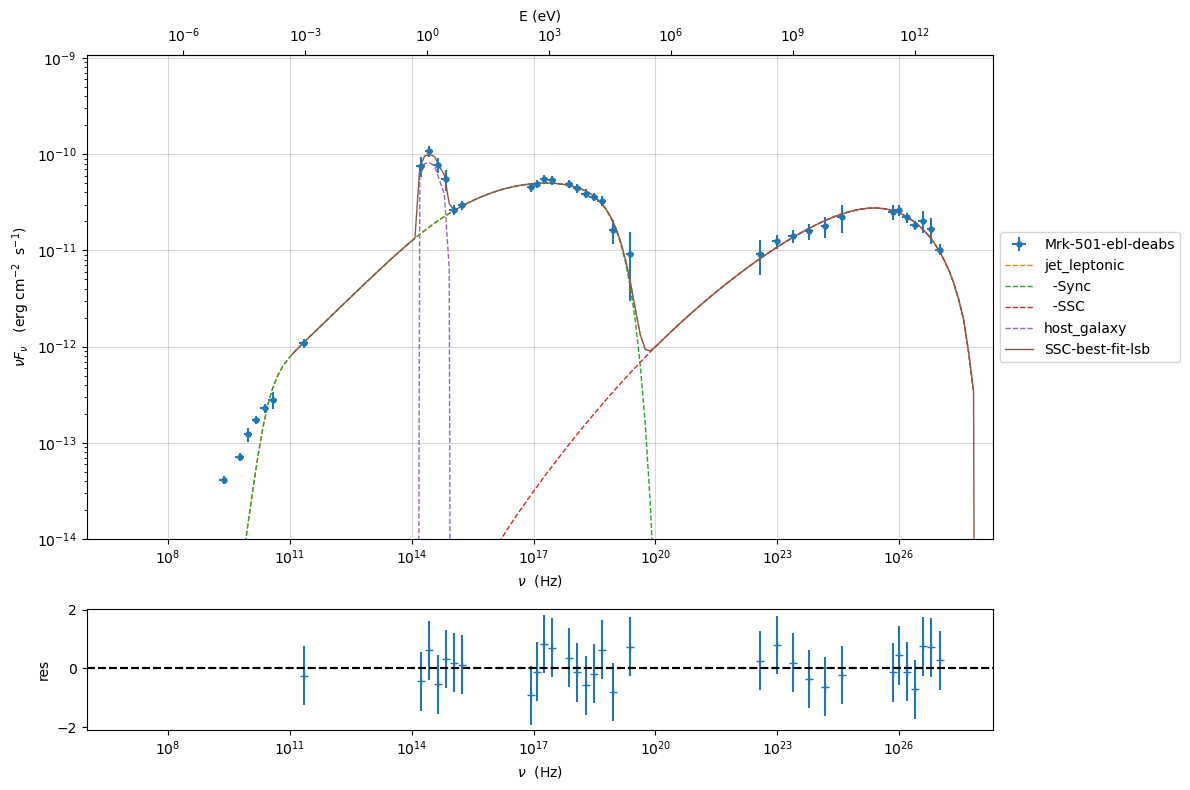

In [18]:
%matplotlib inline
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=fit_model_lsb.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

### Model fitting with Minuit

In [19]:
jet_minuit=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_minuit.set_gamma_grid_size(200)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082271e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045836e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205571e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046428e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True


To run the ``minuit`` minimizer we will use the best-fit results from ``lsb`` to set the boundaries for our parameters. 


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-minuit  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------


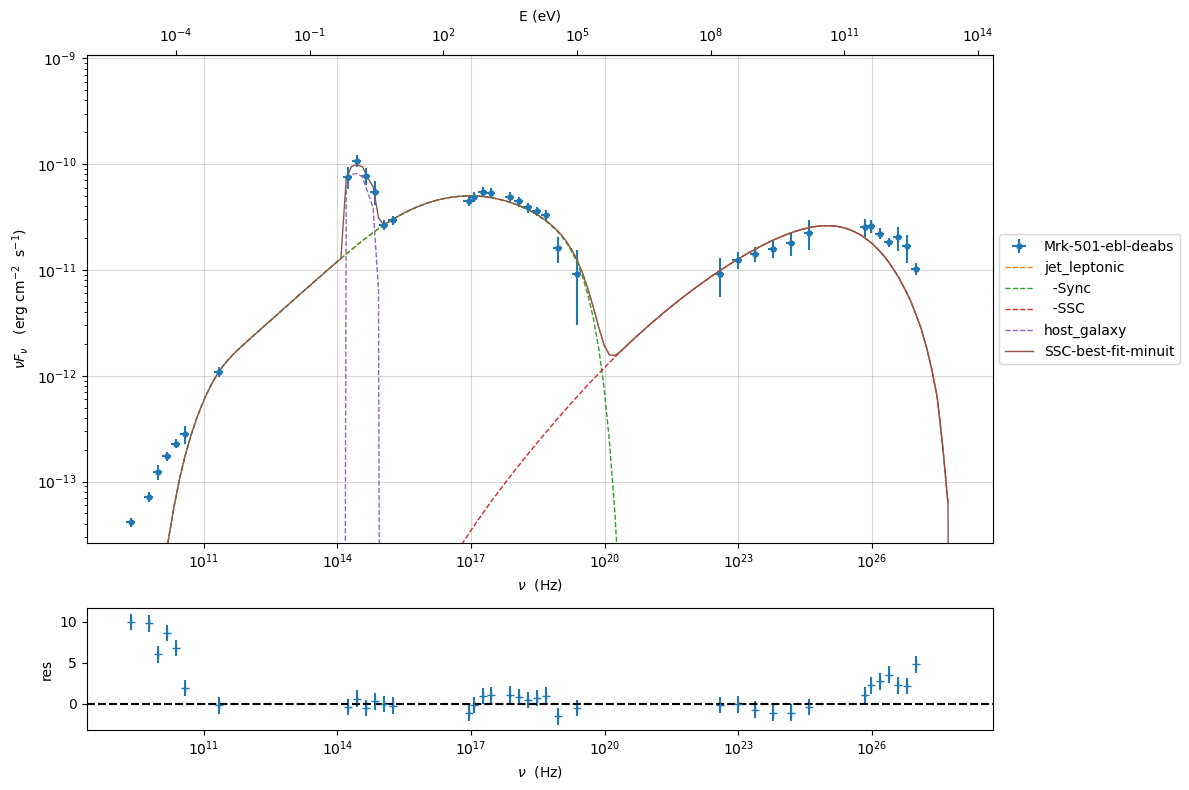

In [20]:
fit_model_minuit=FitModel( jet=jet_minuit, name='SSC-best-fit-minuit',template=my_shape.host_gal) 
fit_model_minuit.show_model_components()
fit_model_minuit.freeze('jet_leptonic','z_cosm')
fit_model_minuit.freeze('jet_leptonic','R_H')
fit_model_minuit.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model_minuit.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_minuit.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_minuit.host_galaxy.parameters.nu_scale.frozen=True
fit_model_minuit.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit.jet_leptonic.parameters.gmax.fit_range=[5E5,1E8]
fit_model_minuit.jet_leptonic.parameters.gamma0_log_parab.fit_range=[1E3,5E5]
fit_model_minuit.composite_expr='jet_leptonic + host_galaxy'
fit_model_minuit.eval()
fit_model_minuit.plot_model(sed_data=sed_data)

In [21]:
model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(fit_model_lsb,sed_data,1E11,1E29,fitname='SSC-best-fit-minuit',repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=8.00875e+00

fit run: 1
- old chisq=8.00875e+00


0it [00:00, ?it/s]

- best chisq=8.00874e+00

fit run: 2
- old chisq=8.00874e+00


0it [00:00, ?it/s]

- best chisq=8.00873e+00

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,8.051831e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.078830e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.450394e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,2.011401e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.075539e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,1.982898e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.461156e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.079074e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True



converged=True
calls=151
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.009                      │              Nfcn = 151              │
│ EDM = 2.53e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │    81     │    12     │            │            │    1    │  1e+09  │       │
│ 1 │ par_1 │  2.08e6   │  0.13e6   │            │            │  10000  │  1e+08  │       │
│ 2 │ par_2 │   24.5    │    3.0    │            │            │  1e-10  │ 100000  │       │
│ 3 │ par_3 │  2.01e3   │  0.30e3   │            │            │    1    │  1e+09  │       │
│ 4 │ par_4 │   2.076   │   0.021   │            │            │   -10   │   10    │       │
│ 5 │ par_5 │   0.198   │   0.010   │            │            │   -15   │   15    │       │
│ 6 │ par_6 │  14.6e15  │  0.7e15   │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7 │  10.8e-3  │  0.7e-3   │            │            │  0.001  │    1    │       │
│ 8 │ par_8 │   45.9    │    1.6    │            │            │    5    │   50    │       │
│ 9 │ par_9 │  -10.06   │   0.05    │            │            │-12.2541 │-8.25412 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│       │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9 │
├───────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ par_0 │       150  8.37e+05     -26.4       151     0.112  -0.00959 -3.52e+15    0.0023     -1.76   0.00179 │
│ par_1 │  8.37e+05  1.58e+10 -1.57e+05 -6.42e+05       353       147 -1.38e+19      1.89  2.29e+03     -57.1 │
│ par_2 │     -26.4 -1.57e+05       8.8      -165  -0.00082  -0.00766  1.53e+14 -0.000221   -0.0911   0.00208 │
│ par_3 │       151 -6.42e+05      -165  8.74e+04      1.73      1.52 -1.57e+16   0.00919      -1.2     0.195 │
│ par_4 │     0.112       353  -0.00082      1.73  0.000441 -0.000108 -1.02e+12  2.53e-07  -0.00178  3.34e-05 │
│ par_5 │  -0.00959       147  -0.00766      1.52 -0.000108  0.000107 -9.71e+11  1.68e-06   0.00164 -3.65e-05 │
│ par_6 │ -3.52e+15 -1.38e+19  1.53e+14 -1.57e+16 -1.02e+12 -9.71e+11   4.5e+29  -1.8e+11 -2.99e+14 -2.74e+11 │
│ par_7 │    0.0023      1.89 -0.000221   0.00919  2.53e-07  1.68e-06  -1.8e+11  5.25e-07  -0.00072 -9.23e-07 │
│ par_8 │     -1.76  2.29e+03   -0.0911      -1.2  -0.00178   0.00164 -2.99e+14  -0.00072      2.71  -0.00261 │
│ par_9 │   0.00179     -57.1   0.00208     0.195  3.34e-05 -3.65e-05 -2.74e+11 -9.23e-07  -0.00261   0.00258 │
└───────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

dof=21
chisq=8.008735, chisq/red=0.381368 null hypothesis sig=0.995107

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,8.051831e+01,8.051831e+01,1.225345e+01,--,1.035366e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.078830e+06,2.078830e+06,1.255638e+05,--,2.110441e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.450394e+01,2.450394e+01,2.966631e+00,--,2.378511e+01,1.000000e-10,1.000000e+05,False
jet_leptonic,gamma0_log_parab,2.011401e+03,2.011401e+03,2.957005e+02,--,6.124079e+03,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.075539e+00,2.075539e+00,2.099835e-02,--,2.183323e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,1.982898e-01,1.982898e-01,1.034803e-02,--,2.298521e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.461156e+16,1.461156e+16,6.705147e+14,--,1.416426e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.079074e-02,1.079074e-02,7.243462e-04,--,1.264063e-02,1.000000e-03,1.000000e+00,False
jet_leptonic,NH_cold_to_rel_e,1.000000e-01,--,--,--,1.000000e-01,0.000000e+00,--,True


-------------------------------------------------------------------------




for further information regardin minuit please refer to https://iminuit.readthedocs.io/en/stable/

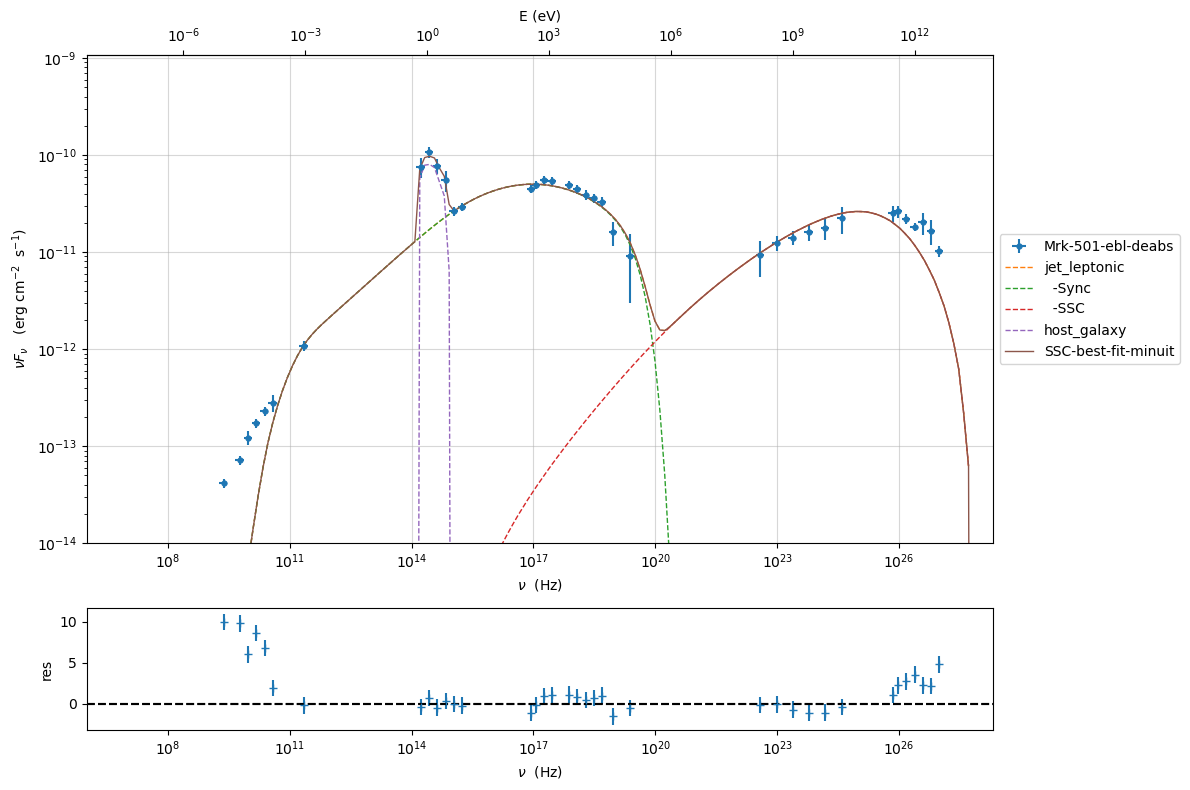

In [22]:
%matplotlib inline
#fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

In [23]:
best_fit_minuit.save_report('SSC-best-fit-minuit.pkl')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model_minuit.save_model('fit_model_minuit.pkl')

best_fit_lsb.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,8.051831e+01,8.051831e+01,1.225345e+01,--,1.035366e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.078830e+06,2.078830e+06,1.255638e+05,--,2.110441e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.450394e+01,2.450394e+01,2.966631e+00,--,2.378511e+01,1.000000e-10,1.000000e+05,False
jet_leptonic,gamma0_log_parab,2.011401e+03,2.011401e+03,2.957005e+02,--,6.124079e+03,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.075539e+00,2.075539e+00,2.099835e-02,--,2.183323e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,1.982898e-01,1.982898e-01,1.034803e-02,--,2.298521e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.461156e+16,1.461156e+16,6.705147e+14,--,1.416426e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.079074e-02,1.079074e-02,7.243462e-04,--,1.264063e-02,1.000000e-03,1.000000e+00,False


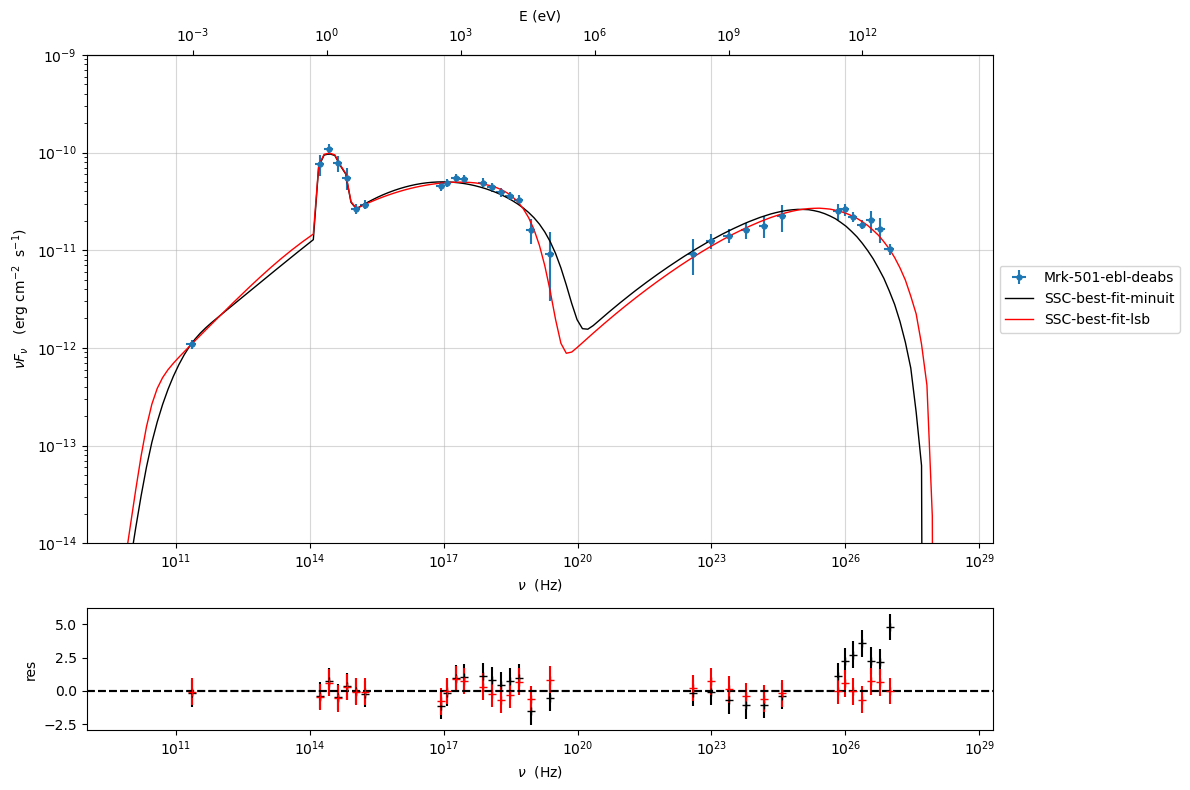

In [24]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 1E11, 1E29])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 1E11, 1E29],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 1E11, 1E29],color='red')
p2.setlim(y_min=1E-14,y_max=1E-9,x_min=1E9,x_max=2E29)

### Model fitting with a bkn pl


In [25]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='bkn',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_bkn_gal_templ.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.092462e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003802e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012034e+05,1.000000e+00,1.000000e+09,False,False


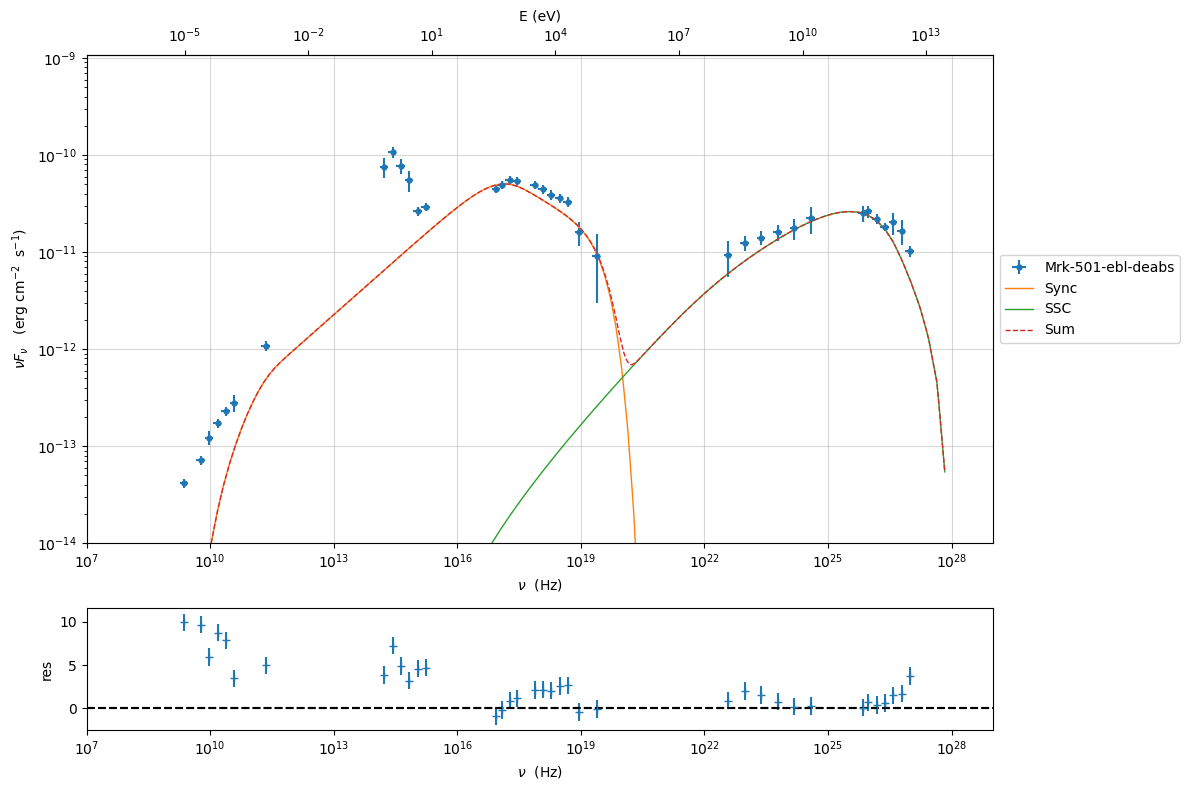

In [26]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.setlim(y_min=1E-14,x_min=1E7,x_max=1E29)

In [27]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)

fit_model_lsb_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-bkn-lsb',template=my_shape.host_gal) 


fit_model_lsb_bkn.freeze(jet_lsb,'z_cosm')
fit_model_lsb_bkn.freeze(jet_lsb,'R_H')
fit_model_lsb_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_lsb_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb_bkn.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb_bkn.host_galaxy.parameters.nu_scale.frozen=True

model_minimizer_lsb_bkn=ModelMinimizer('lsb')
best_fit_lsb_bkn=model_minimizer_lsb_bkn.fit(fit_model_lsb_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-lsb',repeat=3)


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003802e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012034e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.092462e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True


filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=1.04227e+01

fit run: 1
- old chisq=1.04227e+01


0it [00:00, ?it/s]

- best chisq=1.04227e+01

fit run: 2
- old chisq=1.04227e+01


0it [00:00, ?it/s]

- best chisq=1.04227e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.578063e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.737075e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.607005e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,5.609071e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248350e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,2.954875e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.396671e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.426935e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True



converged=True
calls=22
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=21
chisq=10.422729, chisq/red=0.496320 null hypothesis sig=0.972884

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.578063e+02,1.578063e+02,1.116631e+02,--,1.927085e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,1.737075e+06,1.737075e+06,4.856857e+05,--,2.993548e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,1.607005e+01,1.607005e+01,8.186096e+00,--,2.003802e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,5.609071e+04,5.609071e+04,2.169650e+04,--,2.012034e+05,1.000000e+00,1.000000e+09,False
jet_leptonic,p,2.248350e+00,2.248350e+00,1.045397e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,p_1,2.954875e+00,2.954875e+00,5.967235e-02,--,3.500000e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,R,1.396671e+16,1.396671e+16,1.159594e+16,--,1.092462e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.426935e-02,1.426935e-02,4.253832e-03,--,3.008910e-02,0.000000e+00,--,False
jet_leptonic,NH_cold_to_rel_e,1.000000e-01,--,--,--,1.000000e-01,0.000000e+00,--,True


-------------------------------------------------------------------------




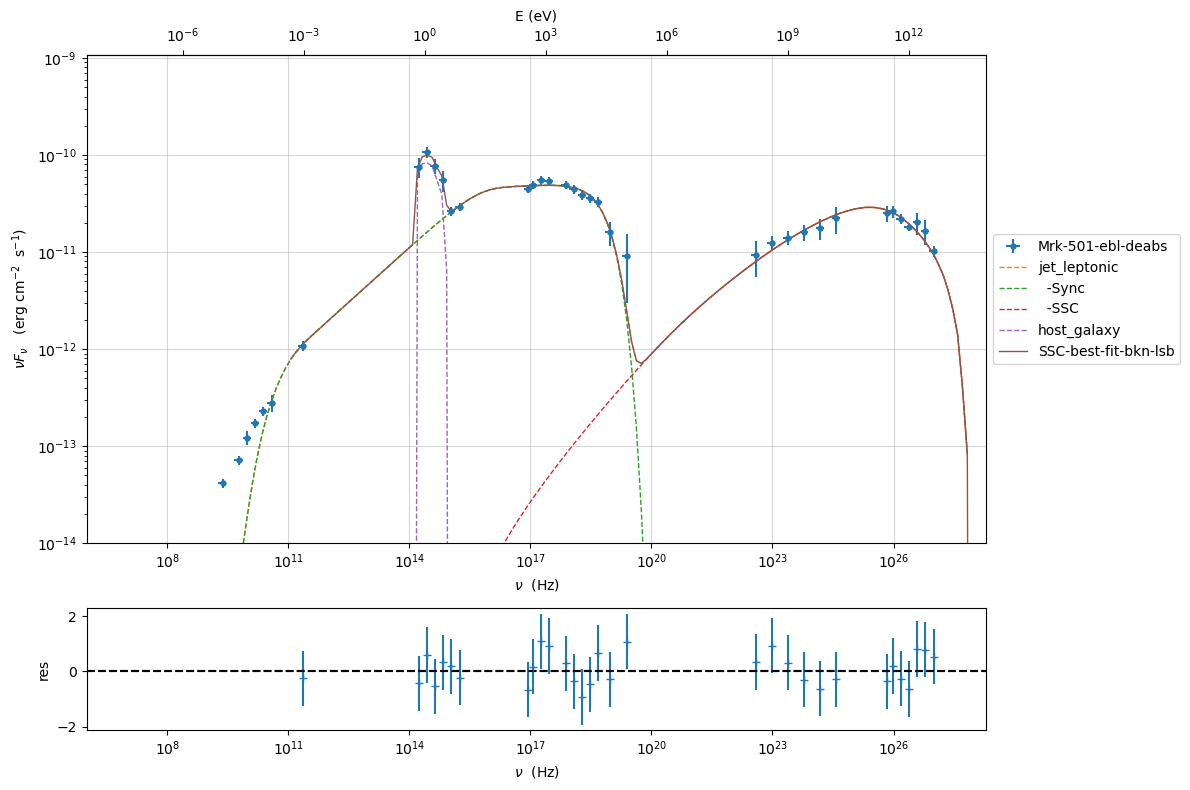

In [28]:
%matplotlib inline
fit_model_lsb_bkn.set_nu_grid(1E6,1E30,200)
fit_model_lsb_bkn.eval()
p2=fit_model_lsb_bkn.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

In [29]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)


fit_model_minuit_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-minuit-bkn',template=my_shape.host_gal) 
fit_model_minuit_bkn.show_model_components()
fit_model_minuit_bkn.freeze('jet_leptonic','z_cosm')
fit_model_minuit_bkn.freeze('jet_leptonic','R_H')
fit_model_minuit_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_minuit_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_minuit_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_minuit_bkn.host_galaxy.parameters.nu_scale.frozen=True
fit_model_minuit_bkn.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit_bkn.jet_leptonic.parameters.gmax.fit_range=[5E5,1E8]
fit_model_minuit_bkn.jet_leptonic.parameters.gamma_break.fit_range=[1E3,1E6]
fit_model_minuit_bkn.jet_leptonic.parameters.p.fit_range=[1,3]
fit_model_minuit_bkn.jet_leptonic.parameters.p_1.fit_range=[2,5]


model_minimizer_minuit_bkn=ModelMinimizer('minuit')
best_fit_minuit_bkn=model_minimizer_minuit.fit(fit_model_minuit_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-minuit-bkn',repeat=3)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003802e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012034e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.092462e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-minuit-bkn  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=1.04631e+01

fit run: 1
- old chisq=1.04631e+01


0it [00:00, ?it/s]

- best chisq=1.04631e+01

fit run: 2
- old chisq=1.04631e+01


0it [00:00, ?it/s]

- best chisq=1.04631e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit-bkn


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.392405e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.810998e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.681699e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,5.725944e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.244497e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,2.955462e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.504347e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.327360e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True



converged=True
calls=153
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.46                      │              Nfcn = 153              │
│ EDM = 2.49e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │    139    │     9     │            │            │   10    │  1000   │       │
│ 1 │ par_1 │  1.81e6   │  0.14e6   │            │            │ 500000  │  1e+08  │       │
│ 2 │ par_2 │   16.8    │    1.0    │            │            │    0    │         │       │
│ 3 │ par_3 │   57e3    │    9e3    │            │            │  1000   │  1e+06  │       │
│ 4 │ par_4 │   2.244   │   0.022   │            │            │    1    │    3    │       │
│ 5 │ par_5 │   2.955   │   0.031   │            │            │    2    │    5    │       │
│ 6 │ par_6 │  15.0e15  │  0.4e15   │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7 │  0.0133   │  0.0013   │            │            │    0    │         │       │
│ 8 │ par_8 │   39.6    │    0.9    │            │            │    5    │   50    │       │
│ 9 │ par_9 │  -10.05   │   0.05    │            │            │-12.2541 │-8.25412 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│       │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9 │
├───────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ par_0 │      87.8  1.01e+06      2.45  5.39e+04     0.173      0.12   1.4e+15   -0.0094      3.55    0.0304 │
│ par_1 │  1.01e+06  1.85e+10  6.51e+04  8.93e+08  2.49e+03  2.22e+03  2.49e+19      -160  7.21e+04       507 │
│ par_2 │      2.45  6.51e+04     0.938  3.75e+03    0.0119    0.0093  3.01e+13 -0.000669     0.261   0.00215 │
│ par_3 │  5.39e+04  8.93e+08  3.75e+03   7.9e+07       157       192  1.12e+18     -8.46  3.41e+03      40.7 │
│ par_4 │     0.173  2.49e+03    0.0119       157  0.000496  0.000331  4.34e+12  -2.4e-05    0.0107  8.18e-05 │
│ par_5 │      0.12  2.22e+03    0.0093       192  0.000331  0.000985  2.28e+12 -1.78e-05    0.0118  2.89e-05 │
│ par_6 │   1.4e+15  2.49e+19  3.01e+13  1.12e+18  4.34e+12  2.28e+12  1.45e+29 -2.49e+11  8.15e+12  3.86e+11 │
│ par_7 │   -0.0094      -160 -0.000669     -8.46  -2.4e-05 -1.78e-05 -2.49e+11  1.65e-06 -0.000807 -5.07e-06 │
│ par_8 │      3.55  7.21e+04     0.261  3.41e+03    0.0107    0.0118  8.15e+12 -0.000807     0.899     0.001 │
│ par_9 │    0.0304       507   0.00215      40.7  8.18e-05  2.89e-05  3.86e+11 -5.07e-06     0.001   0.00229 │
└───────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

dof=21
chisq=10.463081, chisq/red=0.498242 null hypothesis sig=0.972251

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.392405e+02,1.392405e+02,9.368492e+00,--,1.927085e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,1.810998e+06,1.810998e+06,1.361533e+05,--,2.993548e+06,5.000000e+05,1.000000e+08,False
jet_leptonic,N,1.681699e+01,1.681699e+01,9.685337e-01,--,2.003802e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,5.725944e+04,5.725944e+04,8.884218e+03,--,2.012034e+05,1.000000e+03,1.000000e+06,False
jet_leptonic,p,2.244497e+00,2.244497e+00,2.226013e-02,--,2.248787e+00,1.000000e+00,3.000000e+00,False
jet_leptonic,p_1,2.955462e+00,2.955462e+00,3.138381e-02,--,3.500000e+00,2.000000e+00,5.000000e+00,False
jet_leptonic,R,1.504347e+16,1.504347e+16,3.808209e+14,--,1.092462e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.327360e-02,1.327360e-02,1.285580e-03,--,3.008910e-02,0.000000e+00,--,False
jet_leptonic,NH_cold_to_rel_e,1.000000e-01,--,--,--,1.000000e-01,0.000000e+00,--,True


-------------------------------------------------------------------------




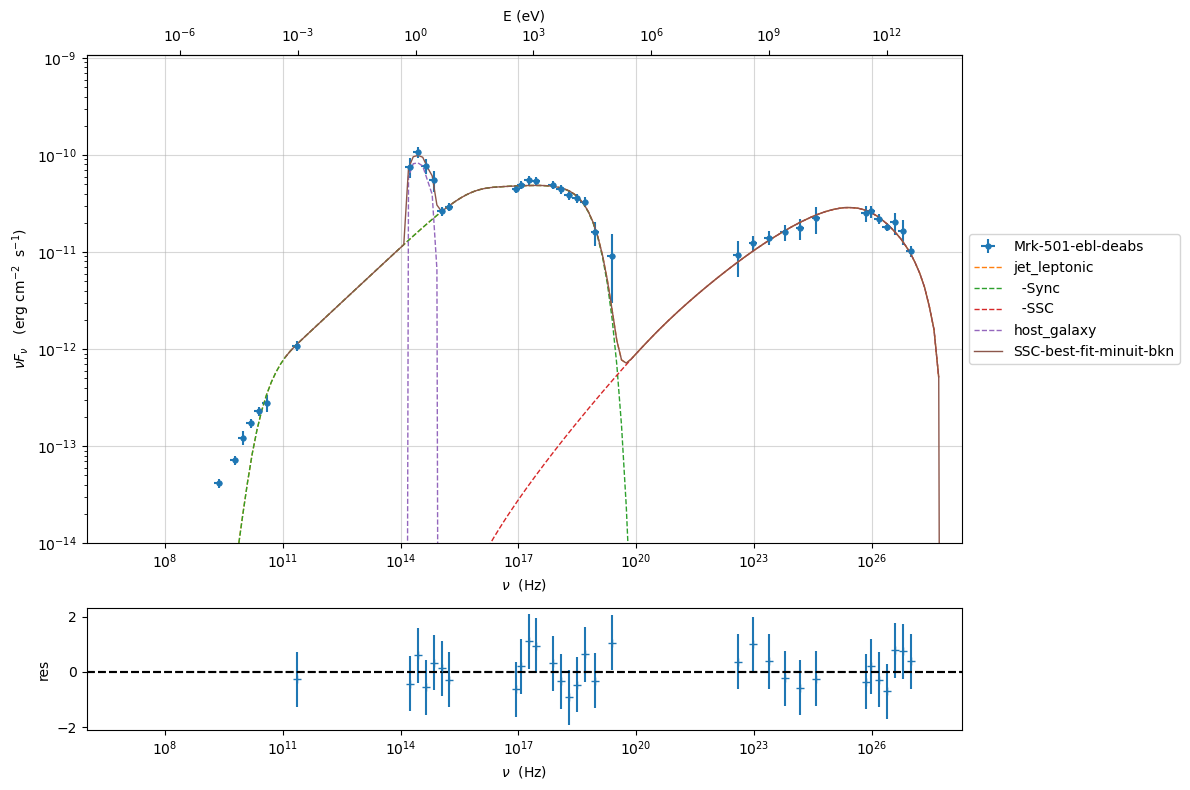

In [30]:
%matplotlib inline
fit_model_minuit_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
p2=fit_model_minuit_bkn.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

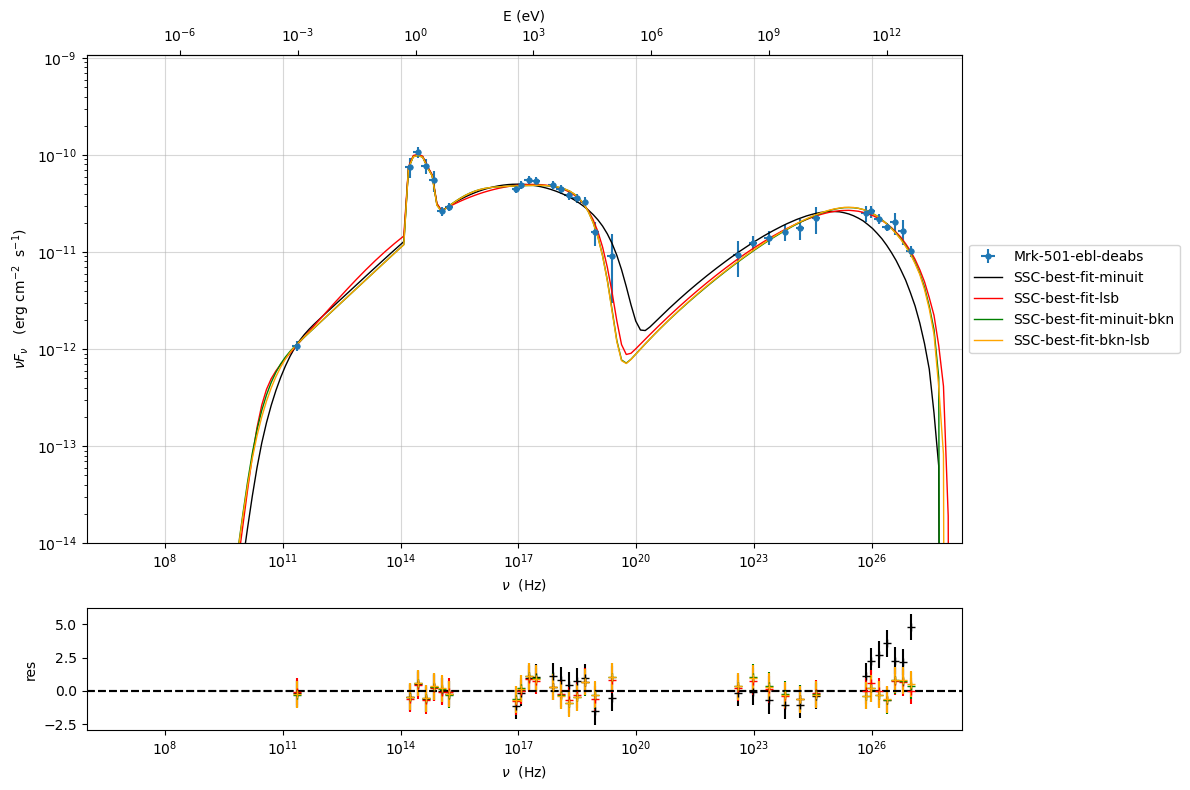

In [31]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
fit_model_lsb_bkn.set_nu_grid(1E6,1E30,200)
fit_model_lsb_bkn.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 1E11, 1E29])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 1E11, 1E29],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 1E11, 1E29],color='red')
p2.add_model_plot(fit_model_minuit_bkn,color='green')
p2.add_residual_plot(fit_model_minuit_bkn,sed_data,fit_range=[ 1E11, 1E29],color='green')
p2.add_model_plot(fit_model_lsb_bkn,color='orange')
p2.add_residual_plot(fit_model_lsb_bkn,sed_data,fit_range=[ 1E11, 1E29],color='orange')
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

## MCMC sampling

In [32]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


We  used a flat prior  centered on the best fit value.   Setting `bound=5.0` and `bound_rel=True` means that:
    
1) the prior interval will be defined as  [best_fit_val - delta_m , best_fit_val + delta_p] 

2) with delta_p=delta_m=best_fit_val*bound

If we set `bound_rel=False` then   delta_p = delta_m = best_fit_err*bound

It is possible to define asymmetric boundaries e.g. `bound=[2.0,5.0]` meaning that 

1) for `bound_rel=True` 

     delta_p = best_fit_val*bound[1]

     delta_m =b est_fit_val*bound[0]

2)  for `bound_rel=False` 

    delta_p = best_fit_err*bound[1]

    delta_m = best_fit_err*bound[0]

In the next release a more flexible prior interface will be added, including different type of priors

Given the large parameter space, we select a sub sample of parameters using the `use_labels_dict`. If we do not pass the 'use_labels_dict' the full set of free parameters will be used



In [33]:
model_minimizer_lsb = ModelMinimizer.load_model('model_minimizer_lsb.pkl')


mcmc=McmcSampler(model_minimizer_lsb)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict)

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 341.68 seconds


In [34]:
print(mcmc.acceptance_fraction)

0.55296875


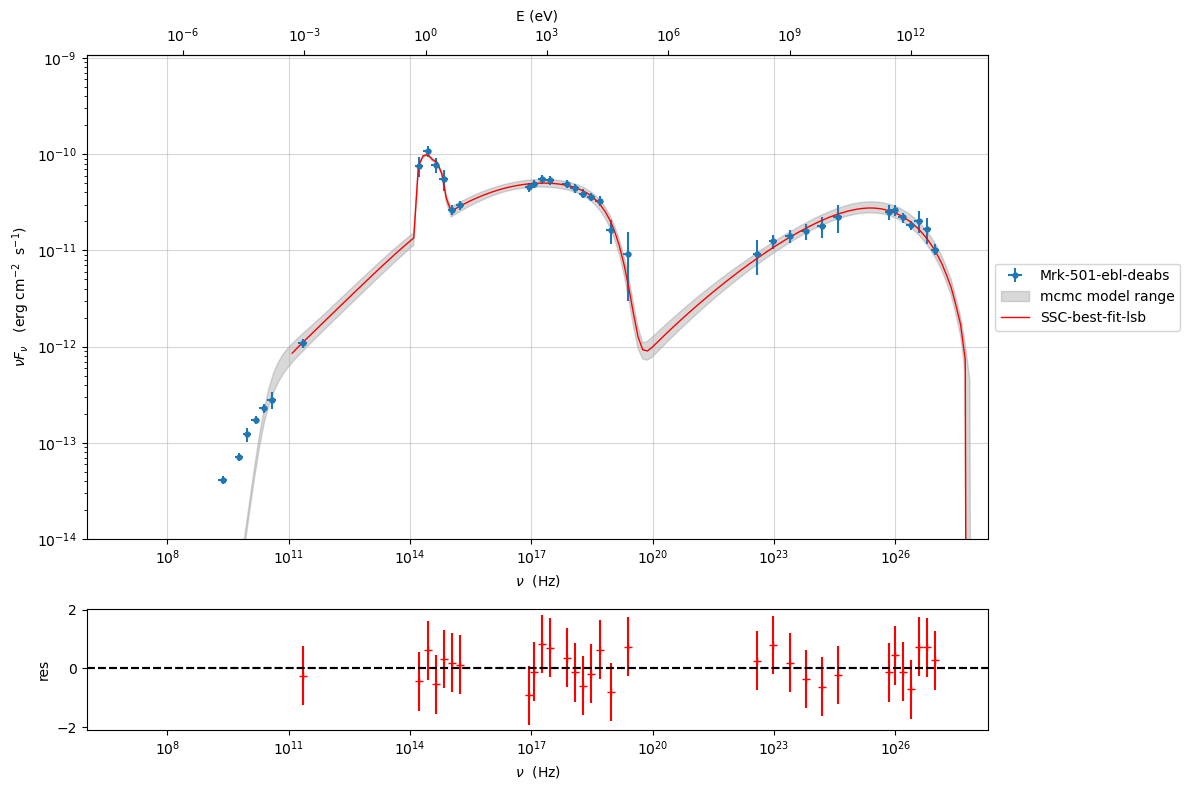

In [35]:
mcmc.model.jet_leptonic.nu_min=1E6
mcmc.model.nu_min=1E6
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E11, 2E28],size=100)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

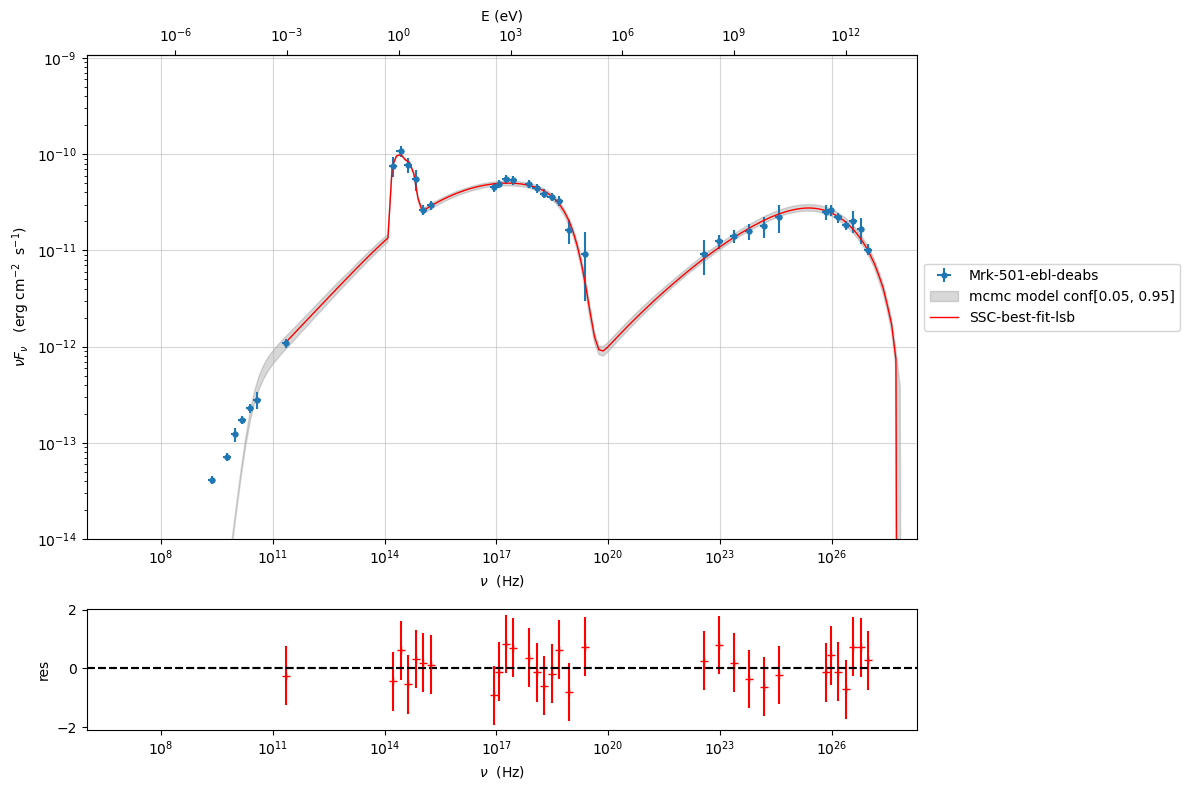

In [37]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[2E11, 2E28],quantiles=[0.05,0.95])
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

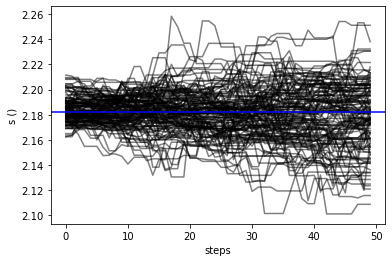

In [38]:
f=mcmc.plot_chain('s',log_plot=False)

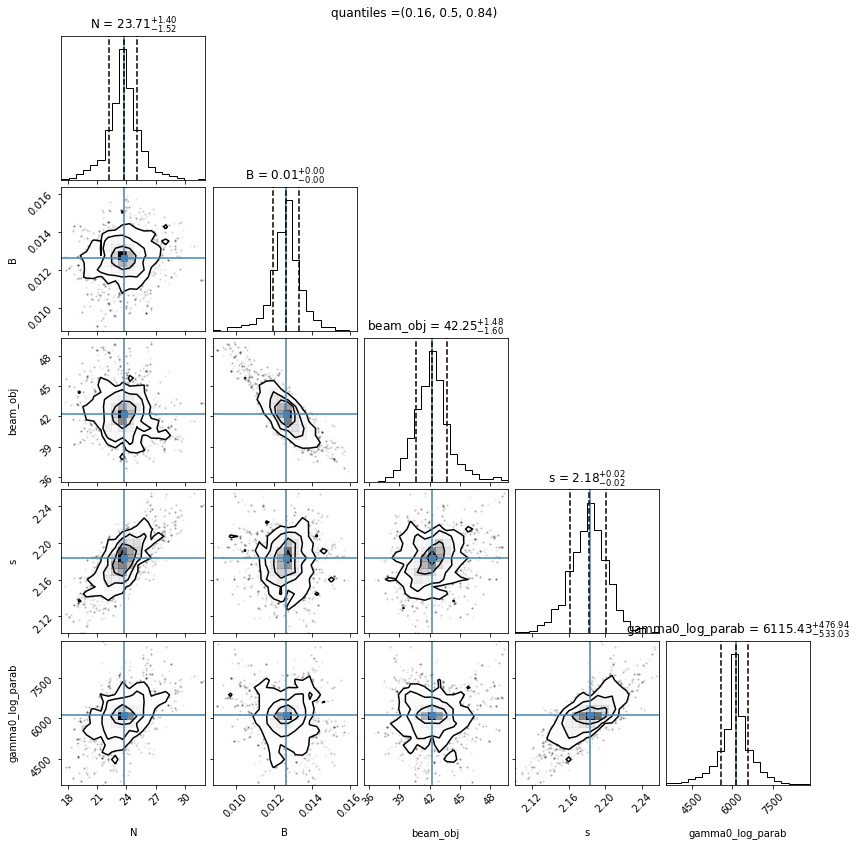

In [39]:
f=mcmc.corner_plot()

In [40]:
mcmc.get_par('N')

(array([23.30777532, 21.06432533, 23.84958056, ..., 22.85071713,
        22.5372472 , 23.2611265 ]),
 0)

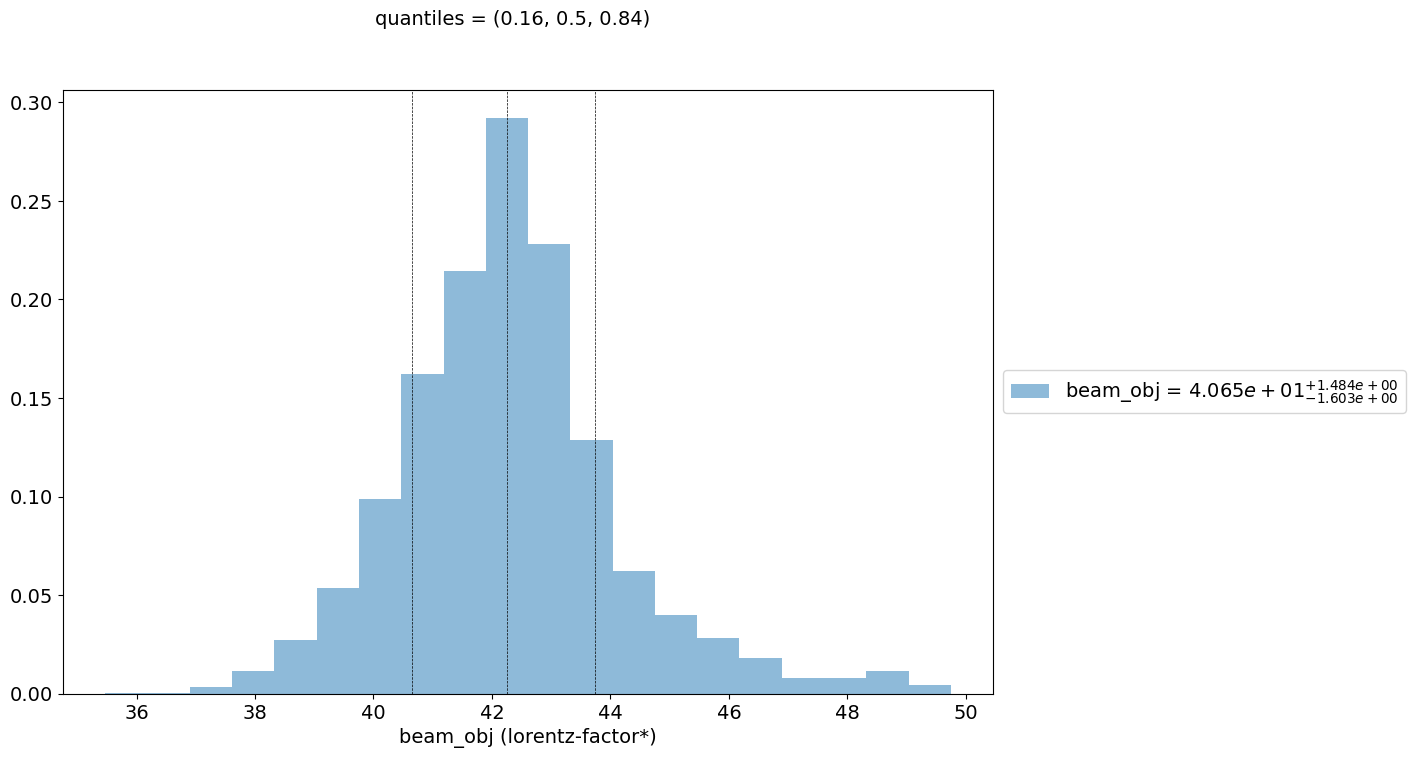

In [41]:
f=mcmc.plot_par('beam_obj')

## Save and reuse MCMC

In [42]:
mcmc.save('mcmc_sampler.pkl')

In [43]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_501.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

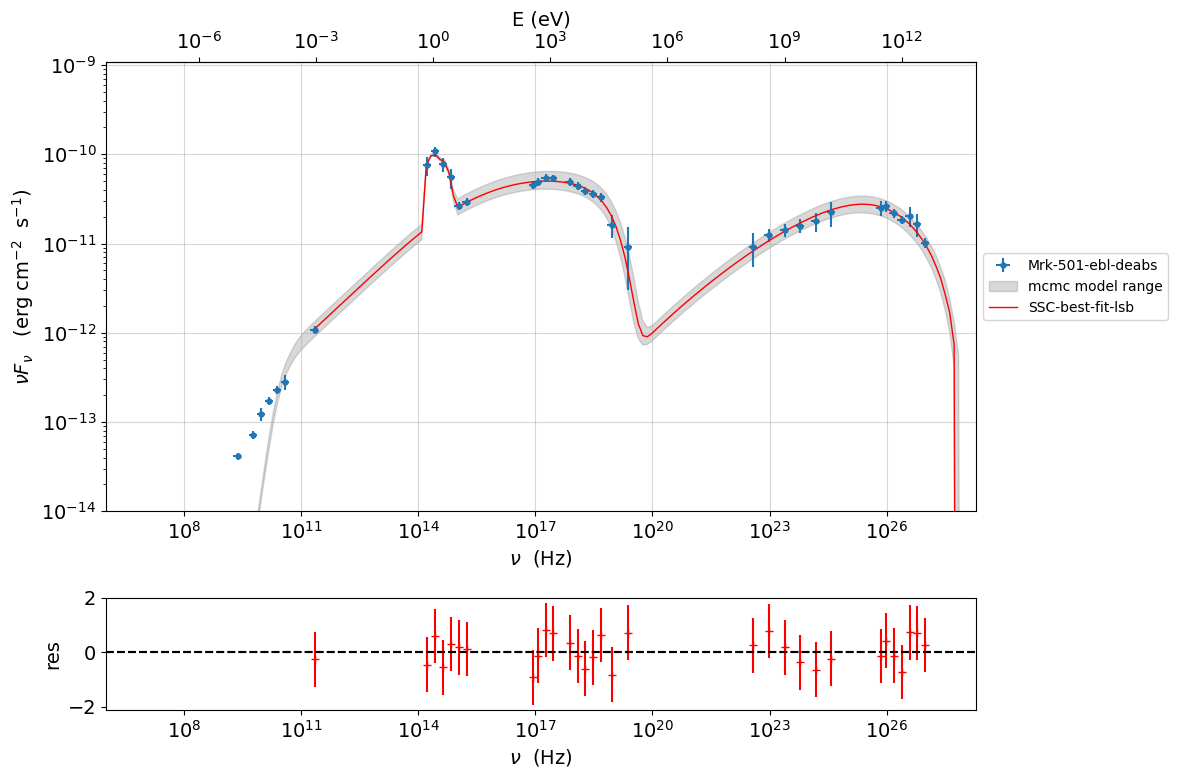

In [44]:
ms.model.nu_min=1E6
ms.model.jet_leptonic.nu_min=1E6
p=ms.plot_model(sed_data=sed_data,fit_range=[2E11, 2E28],size=100)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

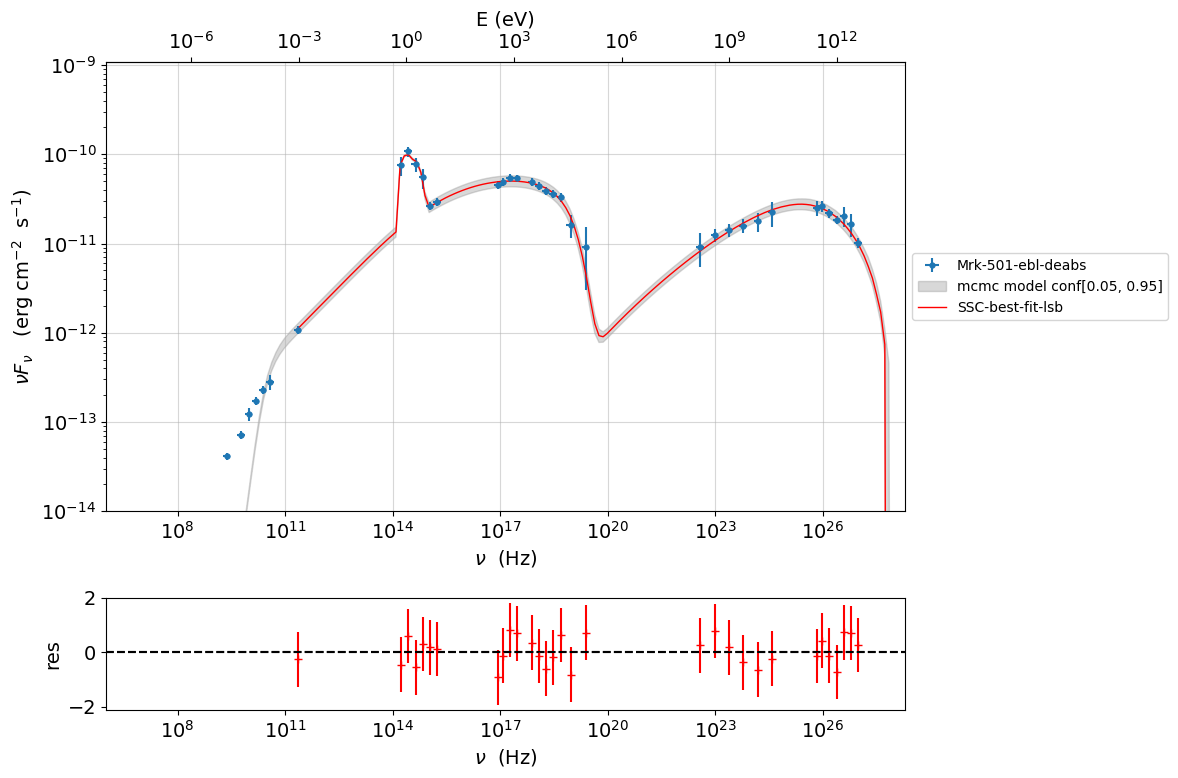

In [45]:
p=ms.plot_model(sed_data=sed_data,fit_range=[2E11, 2E28],quantiles=[0.05,0.95])
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

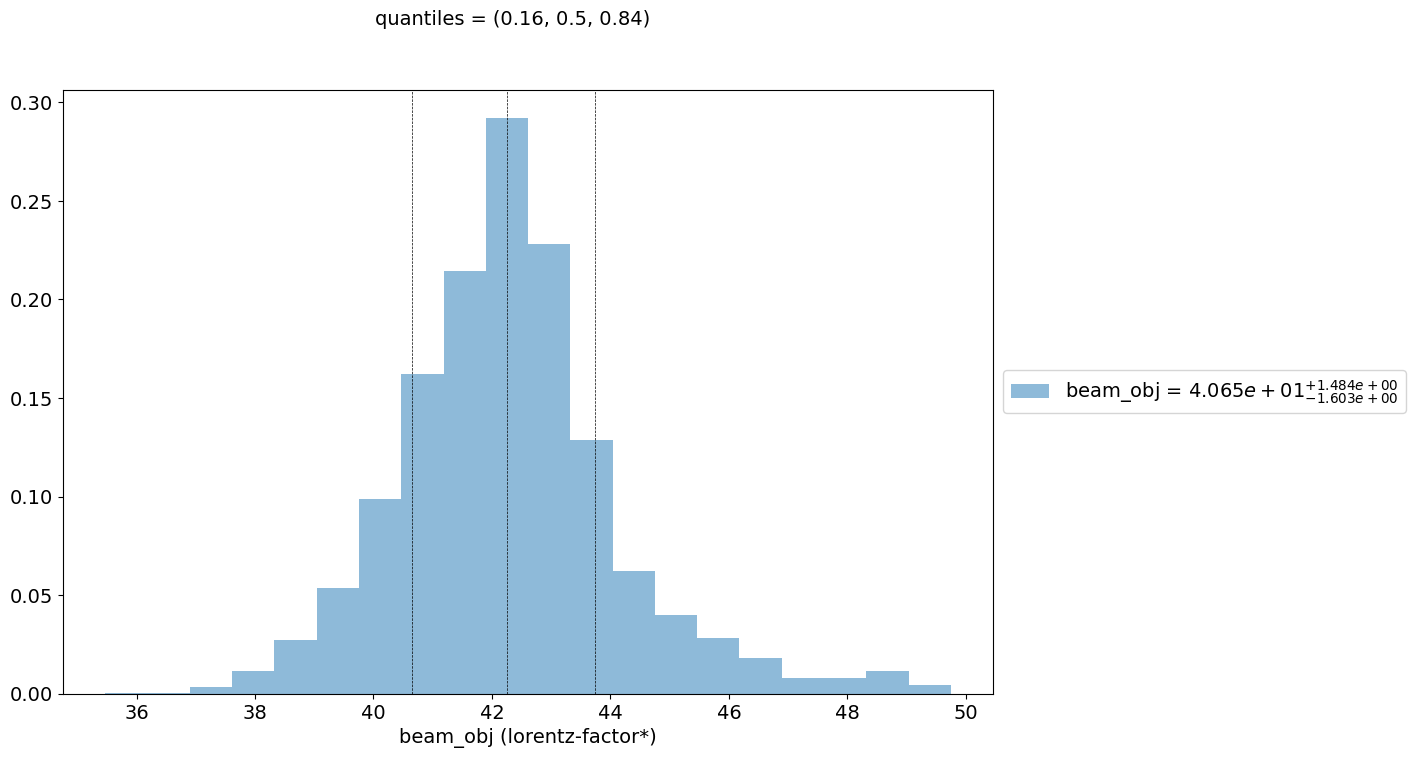

In [46]:
f=ms.plot_par('beam_obj',log_plot=False)


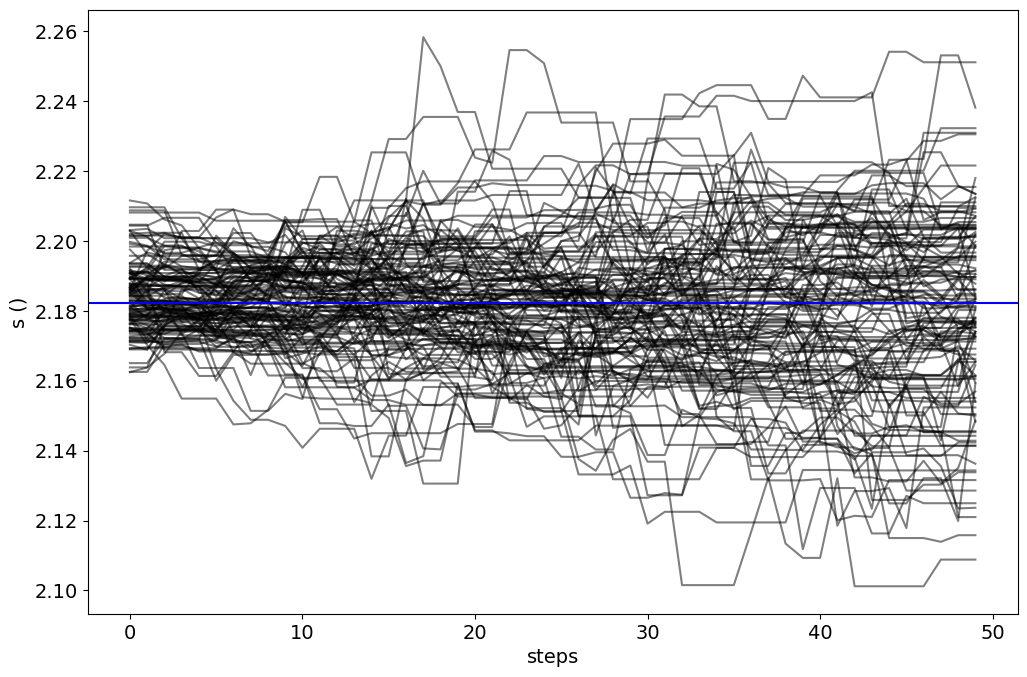

In [47]:
f=ms.plot_chain('s',log_plot=False)